<a href="https://colab.research.google.com/github/rininuruls/PROJECT-UAS-BIG-DATA/blob/main/classification_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, CountVectorizer, IDF,
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("ShopeeProductClassification") \
    .getOrCreate()

# Load data CSV
df = spark.read.csv("/content/sepatu_data_cleaned.csv", header=True, inferSchema=True)

#tampilkan data
df.show(5)


+--------------------+------+-------+-------------+
|               judul| harga|terjual|       lokasi|
+--------------------+------+-------+-------------+
|Jackson Active Ch...|939000|      5|Jakarta Barat|
|Aerostreet 37-40 ...|169900|   6200|  Kab. Klaten|
|PANARYBODY Sepatu...|215000|   2100|    Tangerang|
|[COD]ASNK SEPATU ...|114900|  10000|Jakarta Barat|
|Sepatu Sneakers J...|449000|    943|      Bandung|
+--------------------+------+-------+-------------+
only showing top 5 rows



In [ ]:
# 1. Buat label klasifikasi berdasarkan kolom terjual
df = df.withColumn(
    "label",
    when(df.terjual < 100, 0) \
    .when((df.terjual >= 100) & (df.terjual < 1000), 1) \
    .otherwise(2)
)

In [ ]:
# 2. Transform Judul
tokenizer = Tokenizer(inputCol="judul", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="title_features")

In [ ]:
# 3. Transform Lokasi
tempat_indexer = StringIndexer(inputCol="lokasi", outputCol="tempat_index", handleInvalid="keep")
tempat_encoder = OneHotEncoder(inputCol="tempat_index", outputCol="tempat_encoded")

In [ ]:
# 4. Scaling fitur harga
harga_assembler = VectorAssembler(inputCols=["harga"], outputCol="harga_vec")
harga_scaler = StandardScaler(inputCol="harga_vec", outputCol="harga_scaled")

In [ ]:
# 5. Gabungkan semua fitur menjadi vector features
feature_assembler = VectorAssembler(
    inputCols=["title_features", "tempat_encoded", "harga_scaled"],
    outputCol="features"
)

In [ ]:
# 6. Definisikan model klasifikasi RandomForest
classifier = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

In [ ]:
# 7. Buat pipeline lengkap
pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    vectorizer,
    idf,
    tempat_indexer,
    tempat_encoder,
    harga_assembler,
    harga_scaler,
    feature_assembler,
    classifier
])

In [ ]:
# 8. Bagi data train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 9. Latih model
model = pipeline.fit(train_df)

# 10. Prediksi di data test
predictions = model.transform(test_df)

In [ ]:
# 11. Evaluasi akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6111111111111112


In [ ]:

# 12. Classification

# Tambahkan kolom label_name
predictions = predictions.withColumn(
    "label_name",
    when(predictions.label == 0, "Low") \
    .when(predictions.label == 1, "Medium") \
    .otherwise("High")
)

# (Opsional) Tambahkan juga prediksi label_name
predictions = predictions.withColumn(
    "predicted_label_name",
    when(predictions.prediction == 0, "Low") \
    .when(predictions.prediction == 1, "Medium") \
    .otherwise("High")
)

predictions.select("judul", "harga", "terjual","lokasi", "label_name", "prediction").show(100)

+--------------------+------+-------+---------------+----------+----------+
|               judul| harga|terjual|         lokasi|label_name|prediction|
+--------------------+------+-------+---------------+----------+----------+
|"CaniKorea ""FREE...|136000|   1400| Kab. Tangerang|      High|       2.0|
|(VIBESSTR) NEW ٥٧...|182000|     83|        Bandung|       Low|       2.0|
|Aerostreet 37-40 ...|169900|  10000|    Kab. Klaten|      High|       2.0|
|Aerostreet 37-40 ...|159900|   2600|    Kab. Klaten|      High|       2.0|
|Arvus Gerda Sepat...|115450|   1100|    Kab. Bantul|      High|       2.0|
|BRODO - Sepatu Si...|617000|     38|    Kab. Bekasi|       Low|       0.0|
|COROLLA Blossom S...|189999|  10000| Kab. Tangerang|      High|       2.0|
|GMN Havertz Sepat...|129999|   1500|  Jakarta Timur|      High|       2.0|
|KRONIKEL Karina S...|169900|    467|          Depok|    Medium|       2.0|
|Kenfa - Benze Bla...|265000|   3000|   Kab. Bandung|      High|       2.0|
|Kenfa - Sef

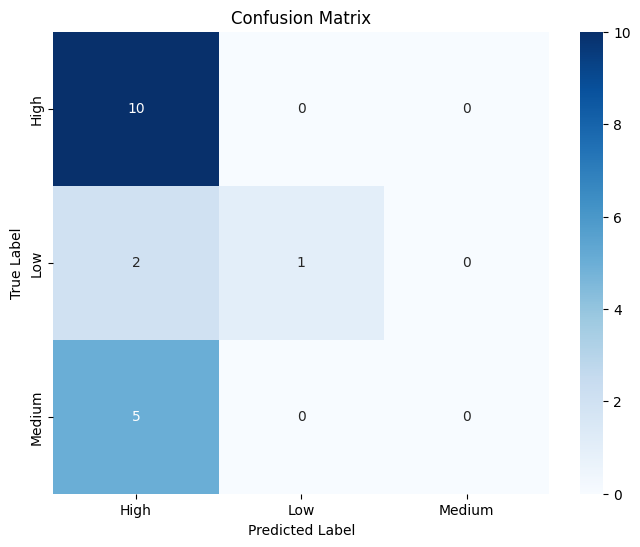

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Konversi DataFrame PySpark ke Pandas
# Pilih kolom yang relevan untuk confusion matrix
pandas_df = predictions.select("label_name", "prediction").toPandas()

# Konversi kolom 'prediction' menjadi string agar sesuai dengan tipe data 'label_name'
# Gunakan mapping yang sama seperti saat membuat 'predicted_label_name'
pandas_df['prediction'] = pandas_df['prediction'].apply(
    lambda x: 'Low' if x == 0 else ('Medium' if x == 1 else 'High')
)


# Confusion Matrix
# Gunakan string labels untuk kedua argumen
cm = confusion_matrix(pandas_df['label_name'], pandas_df['prediction'])
# Dapatkan unique labels dari kolom string
labels = sorted(pandas_df['label_name'].unique())

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
# Pastikan order label di heatmap sama dengan order di confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

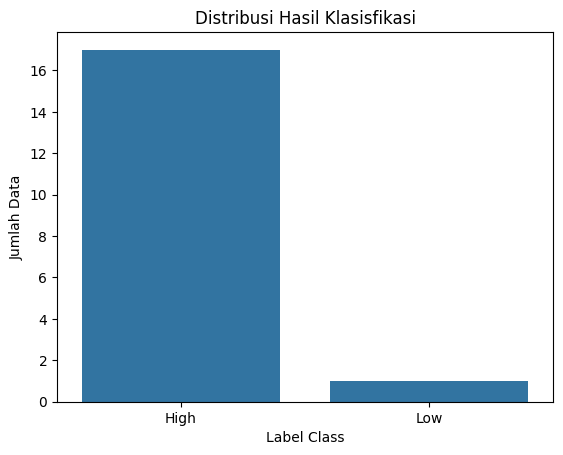

In [ ]:
sns.countplot(x="prediction", data=pandas_df)
plt.title("Distribusi Hasil Klasisfikasi")
plt.xlabel("Label Class")
plt.ylabel("Jumlah Data")
plt.show()

In [ ]:
save = predictions.select("judul", "harga", "terjual","lokasi", "label_name", "prediction")
save.write.csv("predictions.csv", header=True)